# 3. TFIDF Approach

## A. Model

In [11]:
from gensim import utils

def file_to_list(fname):
    with utils.smart_open(fname) as f:
        for rev in f:
            yield rev

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Training Data
clean_train_reviews = []
train_labels = []
for f in ['train_good_reviews.txt',
          'train_bad_reviews.txt']:
    for review in file_to_list(f):
        clean_train_reviews.append(utils.to_unicode(review))
        if "good" in f:
            train_labels.append(1)
        elif "bad" in f:
            train_labels.append(0)
        else:
            raise Exception
        
print("Sample review: %s" % clean_train_reviews[0])
print("Vectorising ... %d reviews" % len(clean_train_reviews))

## Defaults:
#TfidfVectorizer(input='content', encoding='utf-8', decode_error='strict',
#                strip_accents=None, lowercase=True, preprocessor=None,
#                tokenizer=None, analyzer='word', stop_words=None,
#                token_pattern='(?u)\b\w\w+\b', ngram_range=(1, 1),
#                max_df=1.0, min_df=1, max_features=None, vocabulary=None,
#                binary=False, dtype=<class 'numpy.int64'>, norm='l2',
#                use_idf=True, smooth_idf=True, sublinear_tf=False

# 40k, tri-grams, sublinear
vectorizer = TfidfVectorizer(max_features = 40000, ngram_range = (1, 3), sublinear_tf = True)

# Learn vocabulary and idf, return term-document matrix
train_data_features = vectorizer.fit_transform(clean_train_reviews)

del clean_train_reviews

# Training Model

## Defaults used
#LogisticRegression(penalty='l2', dual=False, tol=0.0001, C=1.0, fit_intercept=True,
#                   intercept_scaling=1, class_weight=None, random_state=None,
#                   solver='liblinear', max_iter=100, multi_class='ovr',
#                   verbose=0, warm_start=False, n_jobs=1)

#GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,
#                           subsample=1.0, min_samples_split=2, min_samples_leaf=1,
#                           min_weight_fraction_leaf=0.0, max_depth=3, init=None,
#                           random_state=None, max_features=None, verbose=0, 
#                           max_leaf_nodes=None, warm_start=False, presort='auto')

# l2, max_iter = 100
classifier_tfidf = LogisticRegression(n_jobs=-1)

classifier_tfidf.fit(train_data_features, train_labels)

print("done")

Sample review: it is and does exactly what the description said it would be and would do . couldn ' t be happier with it .

Vectorising ... 999373 reviews
done


In [15]:
classifier_tfidf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## B. Feature Importance

In [16]:
# Tree based estimators can be used to compute feature importances
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the feature importances
# n_jobs = -1 can make this fly!
forest = ExtraTreesClassifier(n_estimators=250, n_jobs=-1)

X, y = train_data_features, train_labels
forest.fit(X, y)

importances = forest.feature_importances_
# Include standard deviation
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)

indices = np.argsort(importances)[::-1]
vocab = vectorizer.get_feature_names()

In [18]:
# Print the feature ranking
feat, feat_imp, feat_std = [], [], []

print("Feature ranking:")
for f in range(20):
    print("%d. feature \"%s\" (%f)" % (f + 1, vocab[int(indices[f])], importances[indices[f]]))
    feat.append(vocab[int(indices[f])])
    feat_imp.append(importances[indices[f]])
    feat_std.append(std[indices[f]])

Feature ranking:
1. feature "not" (0.011544)
2. feature "great" (0.008364)
3. feature "love" (0.005857)
4. feature "waste" (0.003796)
5. feature "and" (0.003290)
6. feature "easy to" (0.003021)
7. feature "disappointed" (0.003010)
8. feature "return" (0.002764)
9. feature "would not" (0.002692)
10. feature "easy" (0.002570)
11. feature "perfect" (0.002526)
12. feature "money" (0.002447)
13. feature "but" (0.002403)
14. feature "at all" (0.002236)
15. feature "do not" (0.002144)
16. feature "very disappointed" (0.002111)
17. feature "waste of" (0.002111)
18. feature "well" (0.002063)
19. feature "did not" (0.002042)
20. feature "highly" (0.002030)


Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


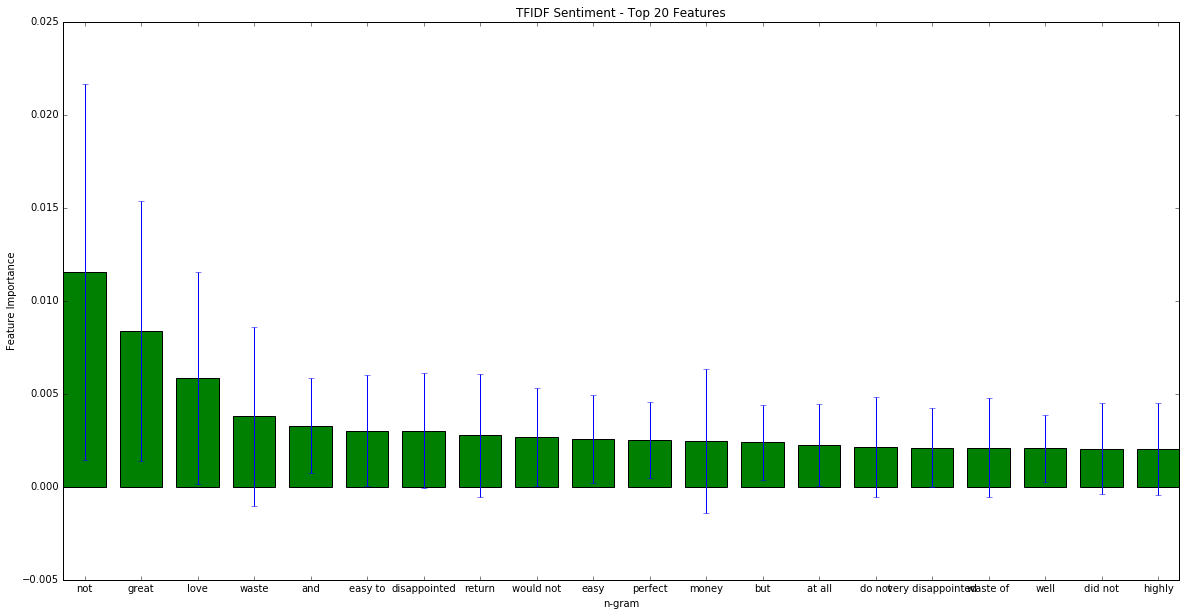

In [19]:
# Plot
%pylab inline
import matplotlib.pyplot as plt

ind = np.arange(len(feat))
width = .75

plt.figure(figsize=(20,10))
plt.xlabel('n-gram')
plt.ylabel('Feature Importance')
plt.title('TFIDF Sentiment - Top 20 Features')

plt.xticks(ind + width/2., (feat))
plt.bar(ind, feat_imp, width, color="g", yerr=feat_std)
plt.show()

In [20]:
del train_data_features
del train_labels
del importances
del vocab
del indices
#del forest

## C. Classification

In [22]:
# Testing Data
clean_test_reviews = []
test_labels = []
for f in ['test_good_reviews.txt',
          'test_bad_reviews.txt']:
    for review in file_to_list(f):
        clean_test_reviews.append(utils.to_unicode(review))
        if "good" in f:
            test_labels.append(1)
        elif "bad" in f:
            test_labels.append(0)
        else:
            raise Exception
                   
print("Sample review: %s" % clean_test_reviews[0])
print("Vectorising ... %d reviews" % len(clean_test_reviews))  

# Transform documents to document-term matrix
test_data_features = vectorizer.transform(clean_test_reviews)

del clean_test_reviews
print("done")

Sample review: easy to use a mobile . if you ' re taller than ft , be ready to tuck your legs behind you as you hang and pull .

Vectorising ... 1000627 reviews
done


In [34]:
# Run classifier
classifier_tfidf.score(test_data_features, test_labels) 

# 50k gives 0.915
# 500k gives 0.928
# 1mill gives 0.931

0.93074642199341018

In [23]:
# By the way, the forest we trained doesn't do so well:
forest.score(test_data_features, test_labels) 

0.89869451853687743

In [24]:
del forest

## D. Evaluate

In [35]:
tricky_sentences = [
    "Most movies are rubbish, however this one was good",
    "This is a product you would love to hate",
    "Rubbish from start to finish",
    "I was so happy when this ended",
    "Very good",
    "Horrible"
]

In [36]:
# Some tests ...
def tfidf_sample_sentiment(mystr):
    assert isinstance(mystr, str)
    test_data_feat = vectorizer.transform([mystr])
    pred = classifier_tfidf.predict(test_data_feat)
    return pred

for x in tricky_sentences:
    clean = clean_review(x)
    print(clean, tfidf_sample_sentiment(clean))    

most movies are rubbish , however this one was good
 [0]
this is a product you would love to hate
 [0]
rubbish from start to finish
 [0]
i was so happy when this ended
 [1]
very good
 [1]
horrible
 [0]


In [37]:
del vectorizer
del classifier_tfidf
del test_data_features
del test_labels